# Self-organizing maps

## Load seismic data

In [1]:
from segysak.segy import segy_loader

seismic = segy_loader('subcube2.sgy',
                      iline=189, xline=193, cdpx=181, cdpy=185,
                      vert_domain="TWT"
                     )
seismic

/home/matt/miniconda3/envs/geoml/lib/python3.9/site-packages/segysak/segy/_segy_core.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0.00/308k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is INLINE_3D


Converting SEGY:   0%|          | 0.00/308k [00:00<?, ? traces/s]

<xarray.Dataset>
Dimensions:  (iline: 646, xline: 619, twt: 227)
Coordinates:
  * iline    (iline) uint16 52 53 54 55 56 57 58 ... 691 692 693 694 695 696 697
  * xline    (xline) uint16 44 45 46 47 48 49 50 ... 656 657 658 659 660 661 662
  * twt      (twt) float64 848.0 850.0 852.0 ... 1.296e+03 1.298e+03 1.3e+03
    cdp_x    (iline, xline) float32 nan 4.847e+05 4.847e+05 ... nan nan nan
    cdp_y    (iline, xline) float32 nan 9.815e+05 9.815e+05 ... nan nan nan
Data variables:
    data     (iline, xline, twt) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/13)
    ns:                  None
    sample_rate:         2.0
    text:                C01  Created by: OpendTect     (dom. 14 nov. 2021, 1...
    measurement_system:  m
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         subcube2.sgy
    srd:                 None
    datatype:            None
    percentiles:         [-63.040377300312926, -62.62881879561425, -24.492536...
    coord_scalar:        -10.0

In [2]:
import numpy as np

ma = np.percentile(seismic['data'], 99.95)

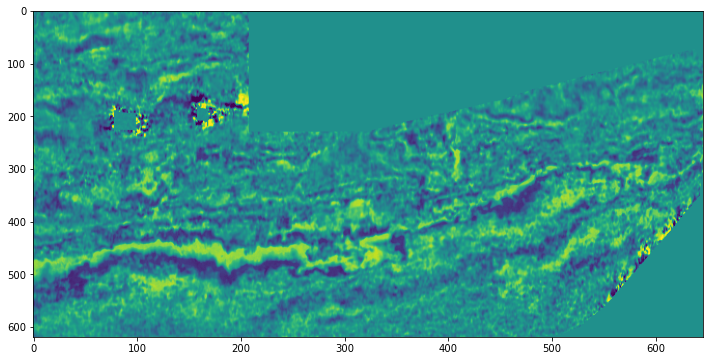

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(seismic['data'][:, :, 100].T, aspect='auto', vmin=-ma, vmax=ma)

## Load horizons

In [4]:
import pandas as pd

names = ["iline", "xline", "twt",
         'F_35','F_45','F_55',
         'Amplitud','firstDeri','secondDeri',
         'Fase', 'Frecuencia','Ancho_de_Banda',
         'Frecuencia_Dominante']

df = pd.read_csv('Horizon_Attributes', names=names, sep="\s+")

df = df.set_index(["iline", "xline"])  # <-- This step is important.

df.head()

twt       F_35       F_45        F_55   Amplitud  \
iline xline                                                             
52    45     1278.331518  215.10142  175.16137  100.759170  16.238707   
      46     1279.500961  206.99444  153.69041   73.653320  15.189196   
      47     1281.668305  235.24234  162.73205   58.803249  16.965900   
      48     1282.426834  274.46118  193.84280   71.845993  19.155159   
      49     1283.501506  310.45947  224.52076   90.961861  23.068329   

              firstDeri  secondDeri      Fase  Frecuencia  Ancho_de_Banda  \
iline xline                                                                 
52    45     -48.017021   61630.832 -0.104739   177.14604        0.470613   
      46    -270.850890   36286.949 -0.086320   170.49472        2.838020   
      47      67.251205  -53554.648  0.024015   163.61567        0.630875   
      48      89.539520   89673.515 -0.018696   154.81025        0.743959   
      49     117.047780  -91621.984  0.042936   170.57219        0.807546   

             Frecuencia_Dominante  
iline xline                        
52    45                33.795681  
      46                33.333336  
      47                33.333000  
      48                33.332989  
      49                33.333302

Let's take a look:

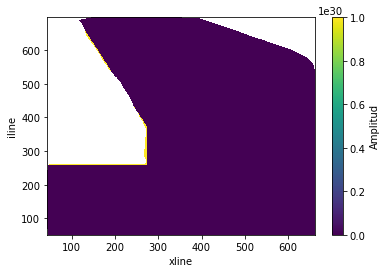

In [6]:
import xarray as xr

amp = xr.DataArray.from_series(df['Amplitud'])
amp.plot()

There are some very large values in here, let's check them:

In [8]:
amp.sel(iline=300, xline=slice(250, 280))

<xarray.DataArray 'Amplitud' (xline: 31)>
array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan, 1.0000000e+30, 1.0000000e+30,
       1.0000000e+30, 1.0000000e+30, 1.0000000e+30, 1.0000000e+30,
       3.7157841e+01, 5.0386402e+01, 5.5121803e+01, 5.0523319e+01,
       3.9729290e+01, 2.8653376e+01, 2.5163456e+01])
Coordinates:
    iline    int64 300
  * xline    (xline) int64 250 251 252 253 254 255 ... 275 276 277 278 279 280

We'll have to deal with these bad values.

In [9]:
df = df.loc[df['Amplitud'] < 1e3]

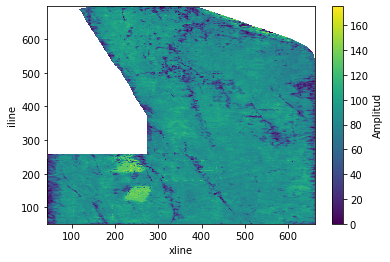

In [10]:
amp = xr.DataArray.from_series(df['Amplitud'])
amp.plot()

Better.

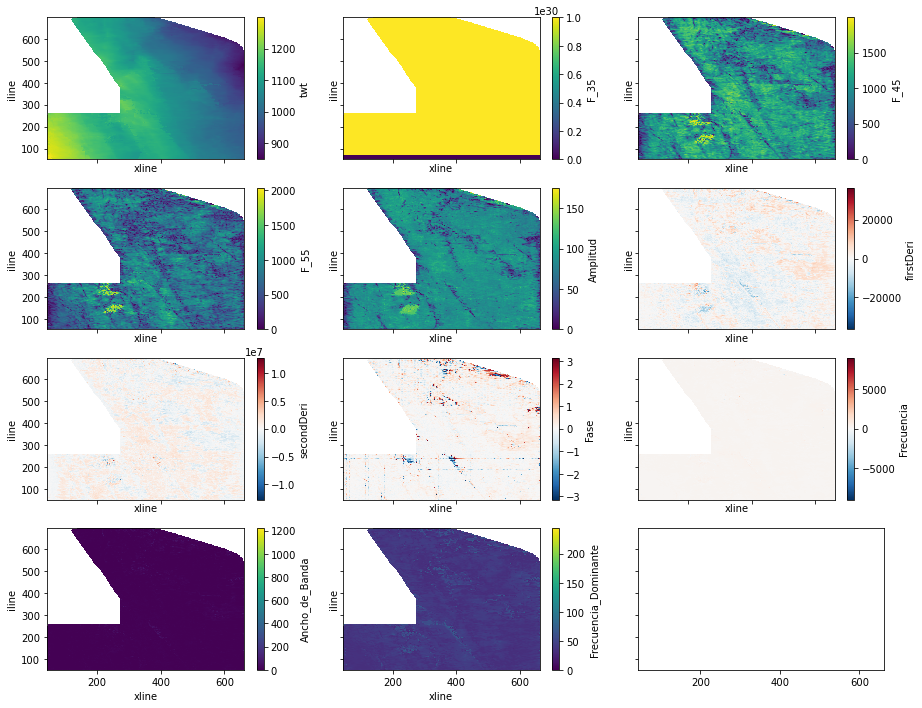

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 12), sharey=True, sharex=True)
for ax, col in zip(axs.flat, df.columns):
    hor = xr.DataArray.from_series(df[col])
    hor.plot.imshow(ax=ax)

Clearly there is a problem with most of the `F_35` horizon, and the `Ancho_de_Banda` and `Frecuencia` horizons seem to need scaling or just don't contain a lot of information.

So I'm going to leave all of those things out.

## Make X

For the input we need a 2D array, with one row per seismic sample and one column per feature (one for amplitude, one for quadrature).

In [12]:
features = [
#     'F_35',
    'F_45',
    'F_55',
    'Amplitud',
    'firstDeri',
    'secondDeri',
    'Fase',
#     'Frecuencia',
#     'Ancho_de_Banda',
    'Frecuencia_Dominante',
]

X = df.loc[:, features].values

## Preprocess

In [13]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

## SOM

In [14]:
from sklearn_som.som import SOM

Now, just like with any classifier right from sklearn, we will have to build an SOM instance and call .fit() on our data to fit the SOM.

In [15]:
som = SOM(m=5, n=5, dim=len(features), random_state=42)
som.fit(X, epochs=1)

Make predition and put it in the DataFrame:

In [16]:
df['facies'] = som.predict(X)

## To `xarray.DataArray`

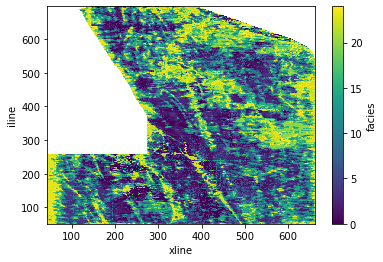

In [17]:
facies = xr.DataArray.from_series(df['facies'])

facies.plot()

## Plot with seismic

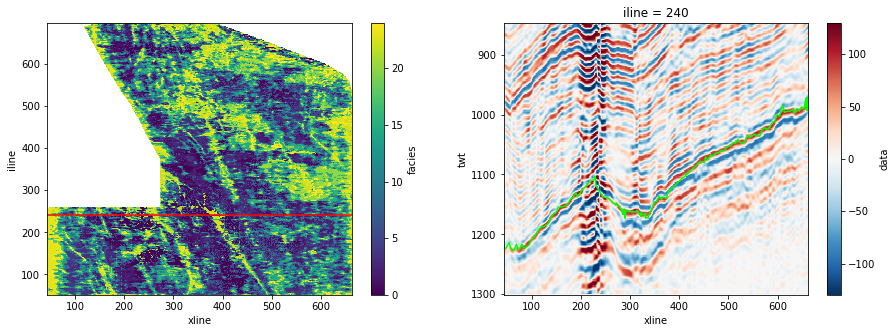

In [34]:
il = 240

twt = xr.DataArray.from_series(df['twt'])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 5))
facies.plot(ax=ax0)
ax0.axhline(il, c='r')
seismic['data'].sel(iline=il).T.plot.imshow(ax=ax1, origin='upper')
twt.sel(iline=il).plot(ax=ax1, c=(0, 1, 0))
plt.show()